<a href="https://colab.research.google.com/github/hoveidar/Neural-Network-Pruning/blob/master/for_ai_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
import pandas as pd


print(tf.__version__)

1.14.0-rc1


In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

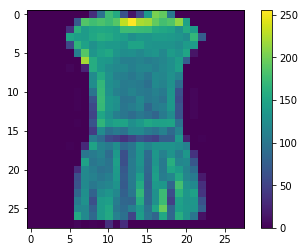

In [5]:
plt.figure()
plt.imshow(train_images[3])
plt.colorbar()
plt.grid(False)
plt.show()

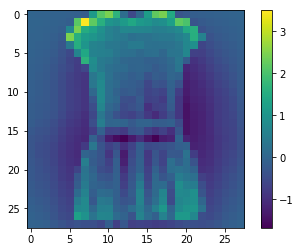

In [6]:
train_images = train_images.reshape((-1,28*28))
test_images = test_images.reshape((-1,28*28))

scaler = preprocessing.StandardScaler().fit(train_images)



train_images = scaler.transform(train_images)
test_images = scaler.transform(test_images)

train_images = train_images.reshape((-1,28,28))
test_images = test_images.reshape((-1,28,28))

plt.figure()
plt.imshow(train_images[3])
plt.colorbar()
plt.grid(False)
plt.show()


# train_images = train_images / 255.0

# test_images = test_images / 255.0

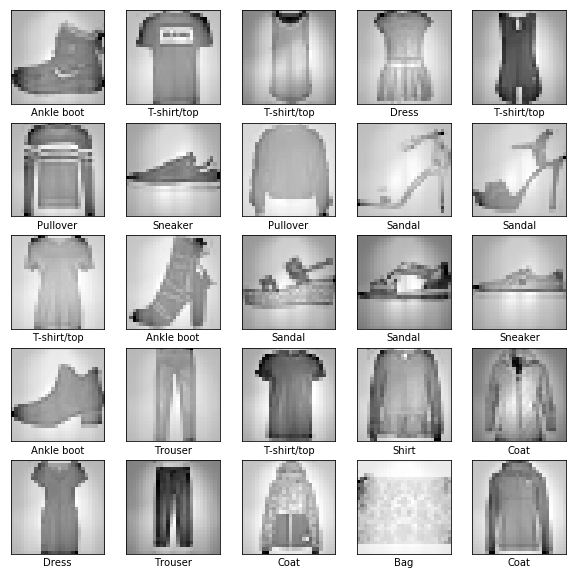

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [8]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(1000, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(1000, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(500, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(200, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(10, activation=tf.nn.softmax,use_bias=False)
])

W0621 21:25:25.358000 140675338958720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(train_images, train_labels, epochs=1)

60000/60000 [==============================] - 52s 862us/sample - loss: 0.4759 - acc: 0.8328


In [0]:
keras.models.save_model(
    model,
    './model',
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

In [0]:
# test_loss, test_acc = model.evaluate(test_images, test_labels)

# print('Test accuracy:', test_acc)

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy after first training:', test_acc)


####################################################################
#defining a function for pruning


def weight_pruning(W,k):
  
  # number of Weight matrices
  W_count = np.shape(W)[0]

  for layer in range(W_count-1): # (W_count-1) is used to prevent pruning of output layer
    temp = W[layer]
    temp_shape = temp.shape
    temp_flatten = temp.reshape(temp_shape[0]*temp_shape[1],)

    temp_abs = np.abs(temp_flatten)

    ind = np.argsort(temp_abs)
    prune_ind = ind[0:int(k*len(ind))]
    for i in prune_ind:
      temp_flatten[i] = 0
    W[layer] = temp_flatten.reshape(temp_shape)
  return W
####################################################################

weight_based_results = pd.DataFrame()

for k in [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]:

  new_model = keras.models.load_model(
      './model',
      custom_objects=None,
      compile=True
  )
  
  # getting weights of the model
  main_weights = new_model.get_weights()

  new_weights = weight_pruning(main_weights,k)
  new_model.set_weights(new_weights)

#   new_model.fit(train_images, train_labels, epochs=3)
  
#   new_weights = weight_pruning(W,k)
#   new_model.set_weights(W)


  new_test_loss, new_test_acc = new_model.evaluate(test_images, test_labels)

  print('Test accuracy after weight pruning of %.2f:'%k, new_test_acc)
  k_step_result = pd.DataFrame({
      'k': [k],
      'Accuracy': [new_test_acc]
  })
  weight_based_results = pd.concat([weight_based_results,k_step_result],axis=0)
  


10000/10000 [==============================] - 2s 239us/sample - loss: 0.4394 - acc: 0.8393
Test accuracy after first training:

W0621 21:26:33.011288 140675338958720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0621 21:26:33.012882 140675338958720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


 0.8393
10000/10000 [==============================] - 2s 238us/sample - loss: 0.4394 - acc: 0.8393
Test accuracy after weight pruning of 0.00: 0.8393
10000/10000 [==============================] - 2s 235us/sample - loss: 0.4401 - acc: 0.8383
Test accuracy after weight pruning of 0.25: 0.8383
10000/10000 [==============================] - 2s 239us/sample - loss: 0.4588 - acc: 0.8324
Test accuracy after weight pruning of 0.50: 0.8324
10000/10000 [==============================] - 2s 244us/sample - loss: 0.4893 - acc: 0.8287
Test accuracy after weight pruning of 0.60: 0.8287
10000/10000 [==============================] - 2s 241us/sample - loss: 0.5842 - acc: 0.8192
Test accuracy after weight pruning of 0.70: 0.8192
10000/10000 [==============================] - 2s 235us/sample - loss: 0.8455 - acc: 0.7990
Test accuracy after weight pruning of 0.80: 0.799
10000/10000 [==============================] - 2s 249us/sample - loss: 1.5492 - acc: 0.7356
Test accuracy after weight pruning of 0.90:

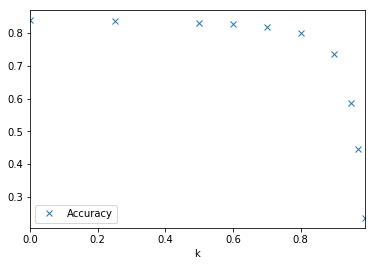

In [14]:
weight_based_results.plot(x='k',y='Accuracy',style='x')


In [15]:
####################################################################
#defining a function for pruning


def unit_pruning(W,k):
  
  # number of Weight matrices
  W_count = np.shape(W)[0]

  for layer in range(W_count-1): # (W_count-1) is used to prevent pruning of output layer
    temp = W[layer]
    temp_shape = temp.shape
#     temp_flatten = temp.reshape(temp_shape[0]*temp_shape[1],)
    temp_norm = np.linalg.norm(temp,axis=0)

#     temp_abs = np.abs(temp_flatten)

    ind = np.argsort(temp_norm)
    prune_ind = ind[0:int(k*len(ind))]
    for i in prune_ind:
      temp[:,i] = 0
      
      
    W[layer] = temp
  return W
####################################################################

unit_based_results = pd.DataFrame()

for k in [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]:

  new_model = keras.models.load_model(
      './model',
      custom_objects=None,
      compile=True
  )
  
  # getting weights of the model
  main_weights = new_model.get_weights()

  new_weights = unit_pruning(main_weights,k)
  new_model.set_weights(new_weights)

#   new_model.fit(train_images, train_labels, epochs=3)
  
#   new_weights = weight_pruning(W,k)
#   new_model.set_weights(W)


  new_test_loss, new_test_acc = new_model.evaluate(test_images, test_labels)

  print('Test accuracy after unit pruning of %.2f:'%k, new_test_acc)
  k_step_result = pd.DataFrame({
      'k': [k],
      'Accuracy': [new_test_acc]
  })
  unit_based_results = pd.concat([unit_based_results,k_step_result],axis=0)

10000/10000 [==============================] - 2s 240us/sample - loss: 0.4394 - acc: 0.8393
Test accuracy after unit pruning of 0.00: 0.8393
10000/10000 [==============================] - 3s 281us/sample - loss: 0.4918 - acc: 0.7996
Test accuracy after unit pruning of 0.25: 0.7996
10000/10000 [==============================] - 3s 253us/sample - loss: 0.7275 - acc: 0.7685
Test accuracy after unit pruning of 0.50: 0.7685
10000/10000 [==============================] - 3s 261us/sample - loss: 1.1428 - acc: 0.6990
Test accuracy after unit pruning of 0.60: 0.699
10000/10000 [==============================] - 3s 260us/sample - loss: 1.6032 - acc: 0.6052
Test accuracy after unit pruning of 0.70: 0.6052
10000/10000 [==============================] - 3s 253us/sample - loss: 2.0768 - acc: 0.4137
Test accuracy after unit pruning of 0.80: 0.4137
10000/10000 [==============================] - 3s 256us/sample - loss: 2.2810 - acc: 0.2960
Test accuracy after unit pruning of 0.90: 0.296
10000/10000 [==

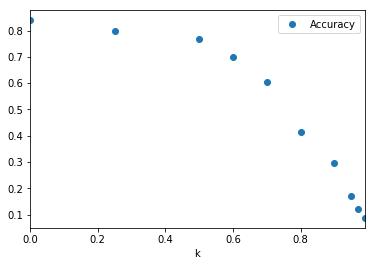

In [17]:
unit_based_results.plot(x='k',y='Accuracy',style='o')
